In [21]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

from typing import Any, Optional, List, Set, Dict, Tuple, Type, Union

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class NoiseInjection(nn.Module):
    r"""
    A, b:       learnable vectors with dimensionality = channels
    alpha, r:   learnable real parameters (alpha in [0, 1], r > 0)
    """
    def __init__(self, channels):
        super(NoiseInjection, self).__init__()
        self.A = torch.nn.Parameter(torch.ones(channels))
        self.b = torch.nn.Parameter(torch.ones(channels))
        self.alpha = torch.nn.Parameter(torch.tensor([np.float32(0.5)]))  
        self.r = torch.nn.Parameter(torch.tensor([np.float32(np.sqrt(channels))]))

    r"""
    x - dnn layer output in B, C, H, W format

    return value: noise with shape (B, C, H, W) to be applied on x (sum)
    """
    def forward(self, x):
        # sigma is (B, C)
        B, C, H, W = x.shape

        sigma = torch.sum(x, dim=[2, 3])

        # take mean/max by dim=1: different images <-> different points 
        # norm_sigma has shape (B, C)

        sigma_max, _ = torch.max(torch.abs(sigma), dim=1, keepdim=True)
        norm_sigma = (sigma - torch.mean(sigma, dim=1, keepdim=True))  
        norm_sigma /=  sigma_max

        sigma = self.alpha * (self.A * norm_sigma + self.b)

        # (1 - self.alpha) with identity matrix
        sigma += (1.0 - self.alpha) * torch.ones_like(sigma)

        # frobenius norm - the standard 2-norm
        sigma = self.r * sigma / torch.linalg.norm(sigma, ord='fro')

        # i don't understand why we should have sigma * (x + eps),
        # and not x + sigma * eps

        #x *= sigma.view(B, C, 1, 1) --- this line is very sus

        return x + sigma.view(B, C, 1, 1) * torch.randn(x.shape, device=x.device)




a = NoiseInjection(channels=3).to(device)
with torch.no_grad():
    t = torch.ones((4, 3, 5, 5)).to(device)
print(a(t))


tensor([[[[ 1.4090,  0.8280,  1.0496,  1.1753,  0.7878],
          [ 1.6275,  0.8809,  1.5943,  0.7397,  1.0353],
          [ 1.3610,  0.6519,  1.2213,  0.4862,  1.6252],
          [ 2.0301,  1.7567,  1.2454,  0.4328,  0.7904],
          [ 0.3040,  0.2333,  0.4070,  0.5094,  0.8003]],

         [[ 1.1773,  0.9158,  1.4120,  1.0935,  1.2108],
          [-0.0904,  0.4482,  1.9435,  1.6397,  1.4592],
          [ 0.7261,  0.1704,  0.7423,  1.8016,  0.1406],
          [ 0.6119,  1.8946,  0.6609,  1.1458,  1.0177],
          [ 1.2139,  0.9623,  0.6153,  1.2908,  1.2456]],

         [[ 1.3929,  0.6823,  1.7428,  1.6101,  0.5888],
          [ 1.5476,  1.6836,  0.9008,  1.2691,  0.8946],
          [ 0.1465,  0.9835,  1.2501,  0.8120,  1.1845],
          [ 1.3959,  0.2733,  1.2894,  0.5962,  0.9104],
          [ 1.2145,  1.2088,  0.9345,  0.3969,  0.6757]]],


        [[[ 0.2793,  1.3602,  0.5633,  0.3845,  0.5951],
          [ 0.4110,  0.9826,  1.6241,  1.3207,  0.0950],
          [ 1.6046,  1.

In [24]:
def leaky_relu(p=0.2, *args, **kwargs):
    return torch.nn.LeakyReLU(p, *args, **kwargs)

def make_act(key: Optional[str], *args, **kwargs):
    if key == "lrelu":
        return leaky_relu(*args, **kwargs)
    elif key == "relu":
        return torch.nn.ReLU(*args, **kwargs)
    elif key == 'tanh':
        return torch.nn.Tanh(*args, **kwargs)
    elif key is None:
        return None
    else: 
        raise ValueError("This type of activation is not supported yet")

def make_norm2d(key: Optional[str], *args, **kwargs):
    if key == 'bn':
        return torch.nn.BatchNorm2d(*args, **kwargs)
    elif key == 'in':
        return torch.nn.InstanceNorm2d(*args, **kwargs)
    elif key is None:
        return None
    else:
        raise ValueError("This type of normalization is not supported yet")



def auto_padding(kernel_size: Union[int, Tuple[int]],
                 dilation: Union[int, Tuple[int]]):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if isinstance(dilation, int):
        dilation = (dilation, dilation)

    return ((kernel_size[0] - 1) // 2 * dilation[0],
            (kernel_size[1] - 1) // 2 * dilation[1])
    
def conv_layer(in_channels, out_channels, kernel_size, stride, dilation, 
               padding_mode='zeros', transpose=False):
    
    padding = auto_padding(kernel_size, dilation)
    if not transpose:
        return nn.Conv2d(in_channels, out_channels, kernel_size, 
                         stride, padding, dilation, padding_mode=padding_mode)
    else:
        if padding_mode != 'zeros':
            raise ValueError("Only zero padding mode is supported with ConvTranspose2d")

        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                  stride, padding, dilation=dilation)





        




        

In [25]:
"""
A class representing a simple Conv2dBlock (conv -> norm -> act -> noise)
"""
class Conv2dBlock(nn.Module):
    r"""
    in_channels:    in_channels for the conv
    out_channels:   out_channels for the conv
    kernel_size:    kernel_size for the conv (def: 3)
    stride:         stride for the conv (def: 1)
    dilation:       dilation for the conv (def: 1)
    transpose:      is conv a Conv2d or a ConvTranspose2d (def: False)
    norm:           type of norm (def: None, supported: 'in'/'bn')
    act:            type of act (def: None, supported: 'lrelu/relu')
    add_noise:      to add noise injection or not (def: False)
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int, Tuple[int]]=3,
                 stride: Union[int, Tuple[int]] = 1,
                 dilation: int = 1,
                 transpose: bool = False,
                 norm: Optional[str] = None,
                 act: Optional[str] = None,
                 add_noise: bool = False):
        super().__init__()
        
        self.conv = conv_layer(in_channels, out_channels, kernel_size, 
                               stride, dilation, transpose=transpose)
        self.norm = make_norm2d(norm, out_channels)
        self.act = make_act(act)
        self.noise = NoiseInjection(out_channels) if add_noise else None

    def forward(self, x):
        x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        if self.act:
            x = self.act(x)
        if self.noise:
            x = self.noise(x)
        return x

in_channels = 256
a = Conv2dBlock(in_channels, in_channels, kernel_size=4, 
                                  stride=2, transpose=True, norm='in', 
                                  act='lrelu', add_noise=False)
a
        

Conv2dBlock(
  (conv): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (act): LeakyReLU(negative_slope=0.2)
)

In [26]:
class UpConv2dBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels):
        
        super().__init__()
        self.t_conv = Conv2dBlock(in_channels, in_channels, kernel_size=4, 
                                  stride=2, transpose=True, norm='in', 
                                  act='lrelu', add_noise=False)
        
        self.conv = Conv2dBlock(in_channels, out_channels, 
                                norm=None, act='lrelu', add_noise=True)

    def forward(self, x):
        return self.conv(self.t_conv(x))

In [27]:
class FusionBlock(nn.Module):
    r"""
        channels:   number of channels (in/out) for input and output
        split:      number of parallel blocks to concatenate (def: 4)
    """
    def __init__(self,
                 channels,
                 split=4):
        
        super().__init__()
        assert channels % split == 0, "split must divide channels"
        assert split > 2, "there should be at least 3 blocks in the parallel layer"
        
        self.head = Conv2dBlock(channels, channels, 
                                kernel_size=3, norm='in', act='lrelu',
                                add_noise=True)
        self.parallel = nn.ModuleList(
            [Conv2dBlock(channels, channels // split, 
                         dilation=2**i, norm='in', 
                         act='lrelu', add_noise=True) for i in range(split)]
                         )
        self.concat_list = nn.ModuleList(
            [Conv2dBlock(channels // split, channels // split, 
                         kernel_size=3) for i in range(split - 1)]
        )

        self.norm = make_norm2d('in', channels)
        self.act = make_act('lrelu')
        self.noise = NoiseInjection(channels)

        self.tail = Conv2dBlock(channels, channels, kernel_size=1, norm='in')

    def forward(self, x):
        x = self.head(x)
        prl_out = [module(x) for module in self.parallel]
        for p, q, layer in zip(prl_out[:-1], prl_out[1:], self.concat_list):
            q = layer(p + q)
        x = torch.cat(prl_out, dim=1)
        x = self.noise(self.act(self.norm(x)))
        return x + self.tail(x)

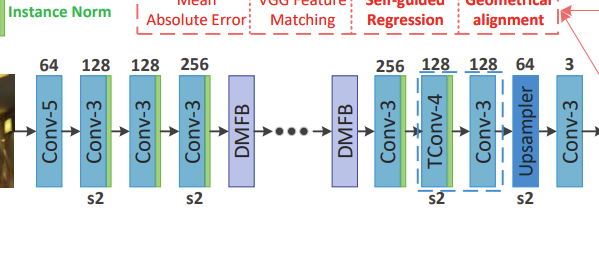

In [30]:
class Generator(nn.Module):
    def __init__(self,
                 resolution,
                 downscale=4,
                 fmap_min=64,
                 fmap_max=256,
                 split=4,
                 fus_blocks_no=4,
                 rgba=False
                 ):
        
        super().__init__()

        log_2_resolution = np.log2(resolution)
        assert resolution == 2 ** log_2_resolution and resolution >= 64
        assert downscale == 2 * np.log2(downscale)
        
        def nf(log_2_f): 
            return int(np.clip(2 ** log_2_f, fmap_min, fmap_max))


        blocks_no = int(np.log2(downscale))
        in_channels = 4 if rgba else 3

        log_2_start = int(np.log2(fmap_max // downscale))
        log_2_end = log_2_start + blocks_no


        self.head = Conv2dBlock(in_channels, nf(log_2_start), 
                                kernel_size=5, act='lrelu', add_noise=True)

        self.mod_seq_bf = nn.Sequential()
        
        for bl in range(1, blocks_no):
            self.mod_seq_bf.add_module(f"conv_s2_{bl}",
                                       Conv2dBlock(nf(log_2_start + bl - 1), 
                                                   nf(log_2_start + bl), 
                                                   stride=2, norm='in', 
                                                   act='lrelu', 
                                                   add_noise=True))
            self.mod_seq_bf.add_module(f"conv_{bl}", 
                                       Conv2dBlock(nf(log_2_start + bl), 
                                                   nf(log_2_start + bl), 
                                                   norm='in', act='lrelu', 
                                                   add_noise=True))
        self.mod_seq_bf.add_module(f"conv_s2_{blocks_no}", 
                                   Conv2dBlock(nf(log_2_start + blocks_no - 1),
                                               nf(log_2_start + blocks_no), 
                                               stride=2, norm='in', act='lrelu',
                                               add_noise=True))
        
        self.fusion_blocks = nn.Sequential(*[FusionBlock(nf(log_2_end)) for \
                                            i in range(fus_blocks_no)])
        
        self.mod_seq_af = nn.Sequential()

        self.mod_seq_af.add_module("conv_1", Conv2dBlock(nf(log_2_end), 
                                                         nf(log_2_end), 
                                                         norm='in', act='lrelu', 
                                                         add_noise=True))
        for bl in range(1, blocks_no + 1):
            self.mod_seq_af.add_module(f"upsample_{bl}", 
                                       UpConv2dBlock(nf(log_2_end - bl + 1), 
                                                     nf(log_2_end - bl)))
            
        self.tail = Conv2dBlock(nf(log_2_start), in_channels, act='tanh')
    
    def forward(self, x):
        x = self.head(x)
        print("head")
        x = self.mod_seq_bf(x)
        print("mod_bf")
        x = self.fusion_blocks(x)
        print("fus")
        x = self.mod_seq_af(x)
        print("mod_af")
        x = self.tail(x)
        print("tail")
        return x  

head
mod_bf
fus
mod_af
tail


tensor([[[[ 3.2796e-02, -1.4155e-03,  1.0374e-01,  ..., -2.3704e-01,
            6.2533e-02,  2.3038e-01],
          [-2.4180e-01,  1.8840e-01, -6.4826e-02,  ..., -2.4304e-01,
           -1.0341e-03, -9.2157e-02],
          [ 1.6252e-01, -5.2152e-01,  5.4341e-02,  ..., -2.3567e-01,
           -1.1655e-02,  2.0312e-02],
          ...,
          [-3.6625e-02, -1.8703e-01, -3.1478e-01,  ...,  9.2518e-02,
           -1.0416e-02, -1.6215e-02],
          [-1.9055e-01, -6.3621e-02, -5.4987e-03,  ...,  1.1309e-01,
            2.4830e-01,  7.7168e-02],
          [-2.9474e-01, -2.9891e-01,  8.9728e-02,  ..., -1.5115e-01,
           -5.8928e-02,  9.0538e-02]],

         [[-1.2428e-01,  2.3318e-01, -1.1703e-01,  ...,  1.3412e-01,
            9.7982e-02, -9.5197e-03],
          [ 1.8106e-01,  3.2457e-02, -8.0639e-02,  ..., -4.2324e-02,
            6.6606e-02,  3.8657e-02],
          [-1.1787e-01,  1.3805e-01,  1.6284e-01,  ..., -4.5848e-02,
            1.5695e-02, -1.8129e-01],
          ...,
     

In [ ]:
torch.cuda.empty_cache()
c = FusionBlock(256, split=4)
d = torch.zeros((1, 256, 256, 256))
print(c(d).shape)
